<a href="https://colab.research.google.com/github/Mustafa-Dara-Ozevin/ML_Algorithms_on_Kaggle_Datasets/blob/master/Sms_Spam_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:


!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list -s ['spam']


kaggle.json
ref                                                 title                                     size  lastUpdated          downloadCount  
--------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  
uciml/sms-spam-collection-dataset                   SMS Spam Collection Dataset              211KB  2016-12-02 19:29:17          55459  
veleon/ham-and-spam-dataset                         Email Spam                                12MB  2019-01-20 16:43:20           2452  
team-ai/spam-text-message-classification            Spam Text Message Classification         208KB  2017-08-20 06:32:31           3716  
ozlerhakan/spam-or-not-spam-dataset                 Spam or Not Spam Dataset                   1MB  2018-12-14 18:32:01           1505  
rtatman/deceptive-opinion-spam-corpus               Deceptive Opinion Spam Corpus            456KB  2017-07-18 16:31:06           2655  
therohk/examine-the-examiner 

In [5]:
!kaggle datasets download -d 'uciml/sms-spam-collection-dataset'
!unzip 'sms-spam-collection-dataset.zip'

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 66.2MB/s]
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [6]:
import pandas as pd

df = pd.read_csv('spam.csv',encoding='latin1')
df = df.dropna(axis=1)
df.columns = ['target','sms']
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [8]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def count_punct(text):
  count = sum([1 for char in text if char in string.punctuation])
  return round(count/len(text),3)*100

df['sms_len'] = df['sms'].apply(lambda x: len(x) - x.count(' '))

df['sms_punct'] = df['sms'].apply(lambda x: count_punct(x))

def clean_text(text):
  text = ''.join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+', text)
  text = [ps.stem(word) for word in tokens if word not in stopwords]
  return text
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,sms,sms_len,sms_punct
0,ham,"Go until jurong point, crazy.. Available only ...",92,8.1
1,ham,Ok lar... Joking wif u oni...,24,20.7
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,3.9
3,ham,U dun say so early hor... U c already then say...,39,12.2
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,3.3


In [9]:
df_features = df[['sms_len','sms_punct','target']]
df_features.head()

,sms_len,sms_punct,target
0,92,8.1,ham
1,24,20.7,ham
2,128,3.9,spam
3,39,12.2,ham
4,49,3.3,ham


In [55]:
ham = df['target'] == 'ham' 
df_ham = df['sms'][ham]
spam = df['target'] == 'spam' 
df_spam= df['sms'][spam]

In [59]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def make_wordcloud(text):
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black',
      stopwords = STOPWORDS).generate(str(text))
  fig = plt.figure(
      figsize = (40, 30),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=5)
  plt.show()


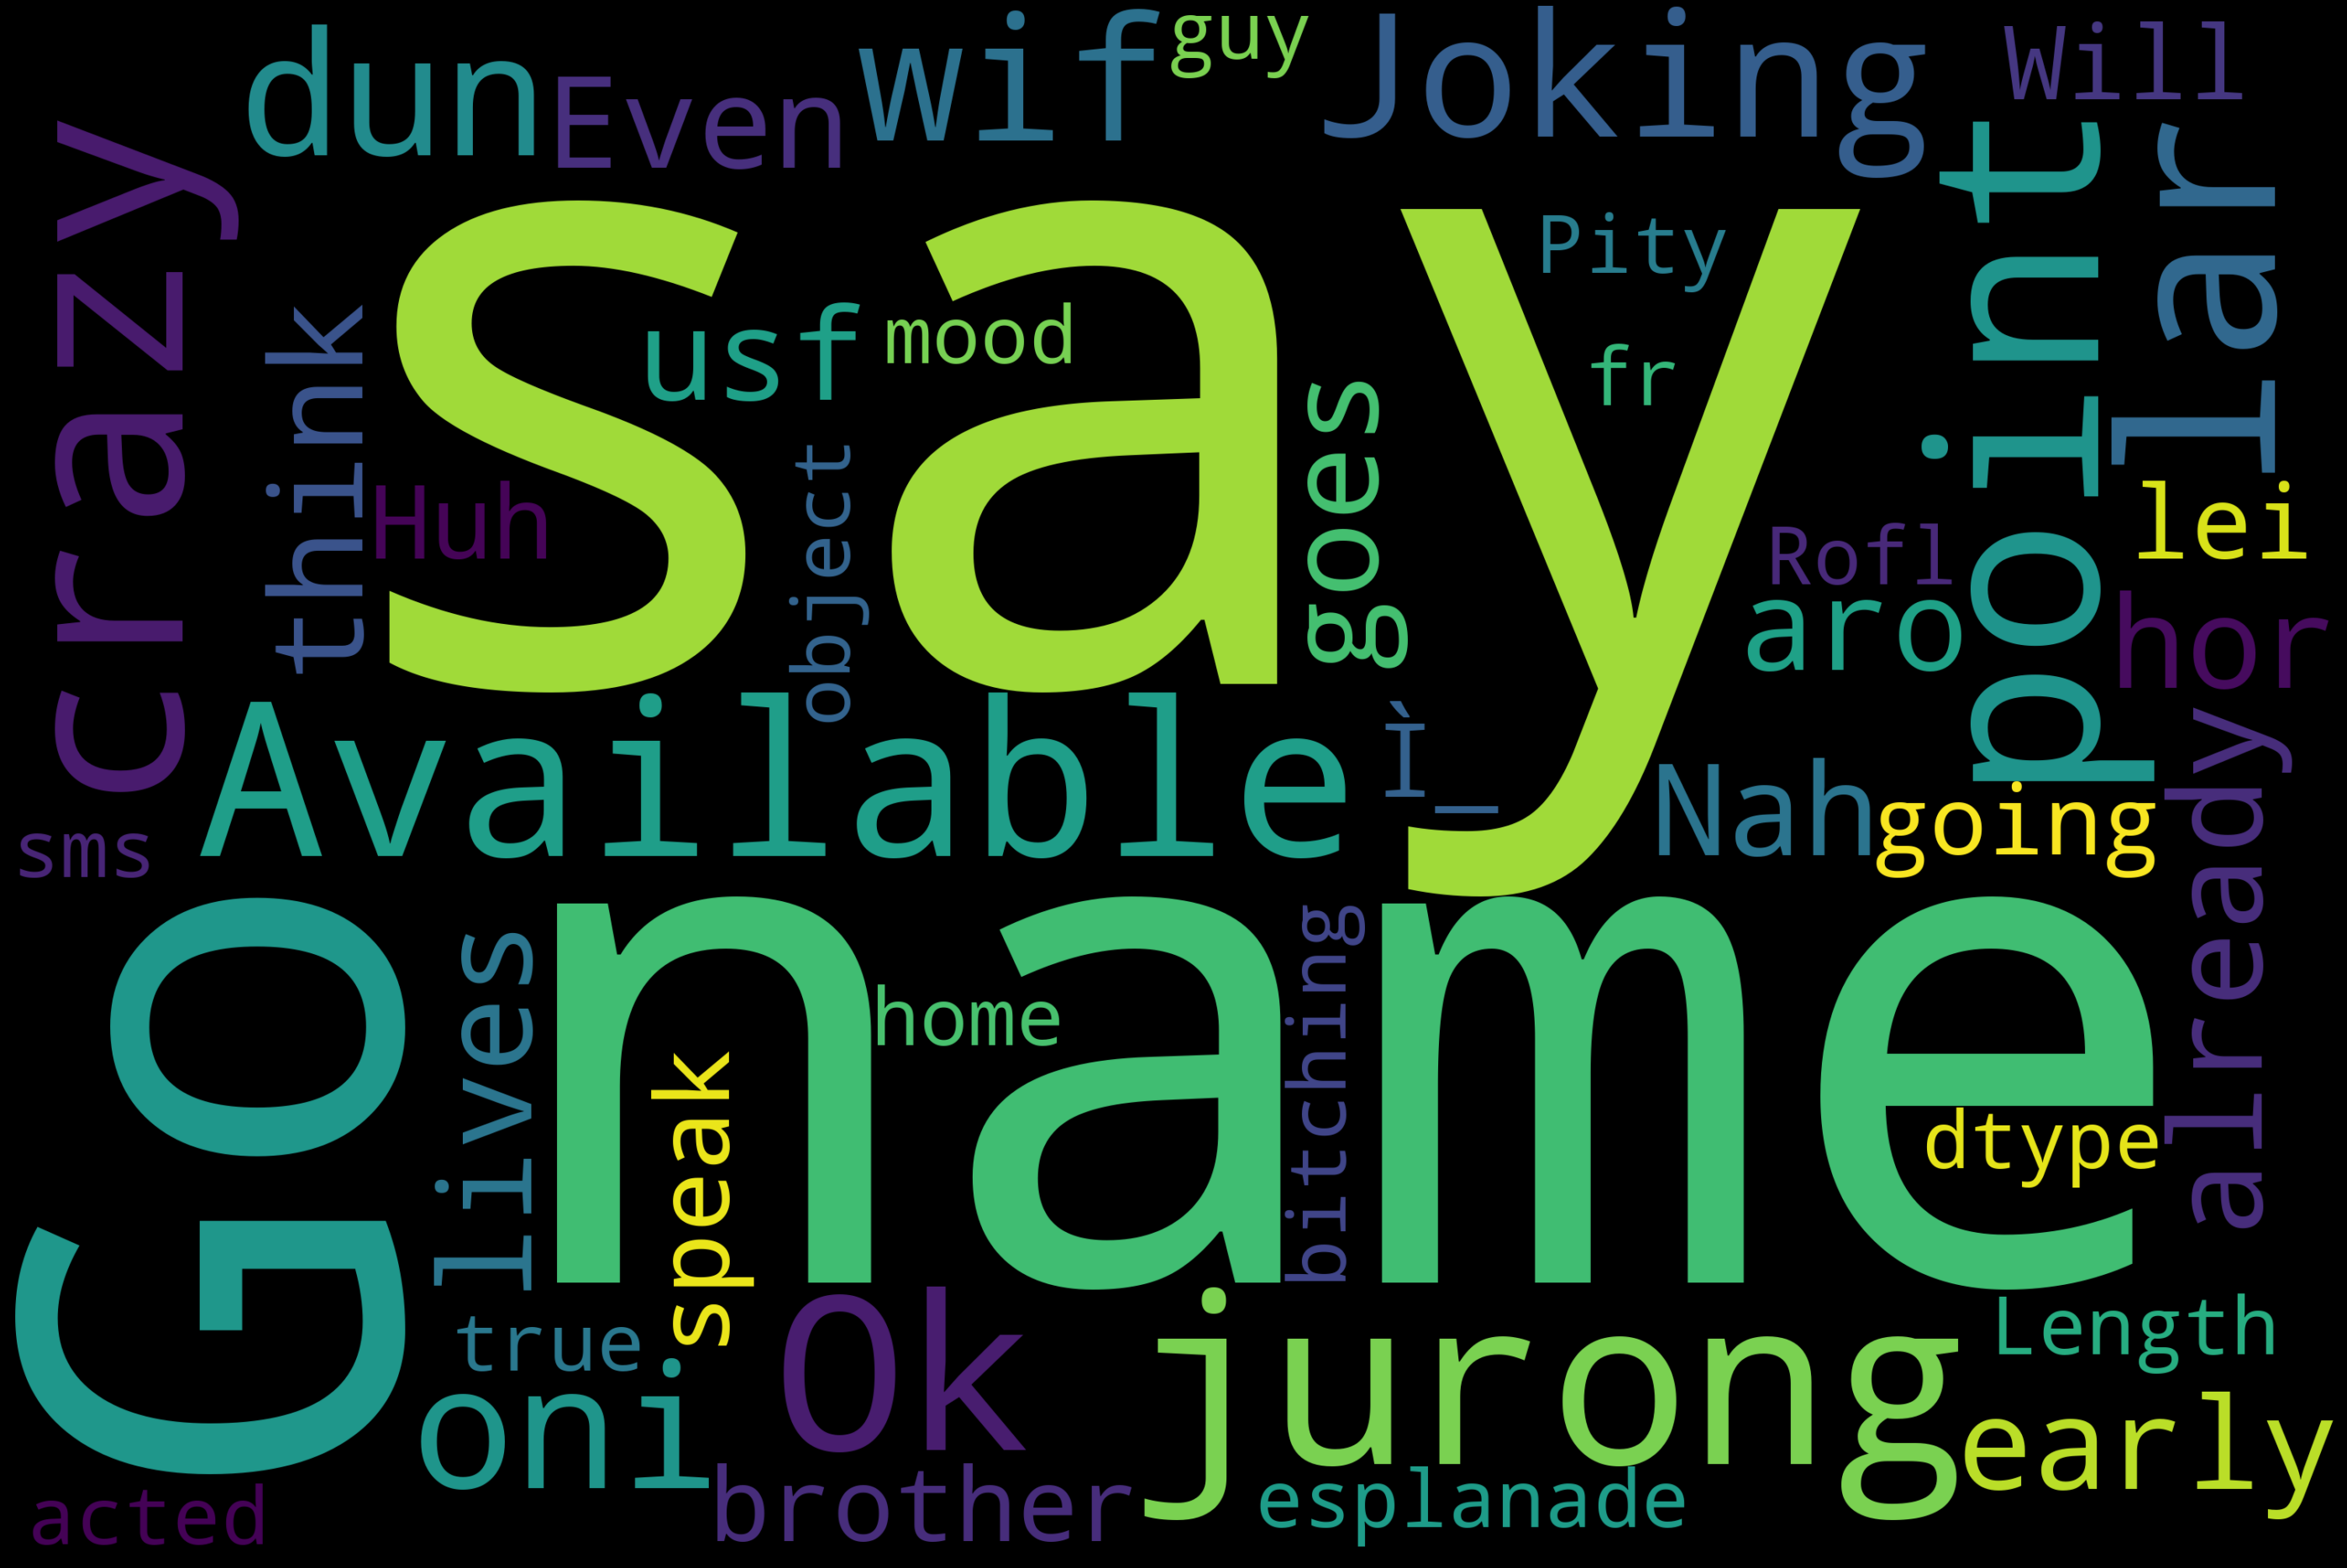

In [60]:
make_wordcloud(df_ham)

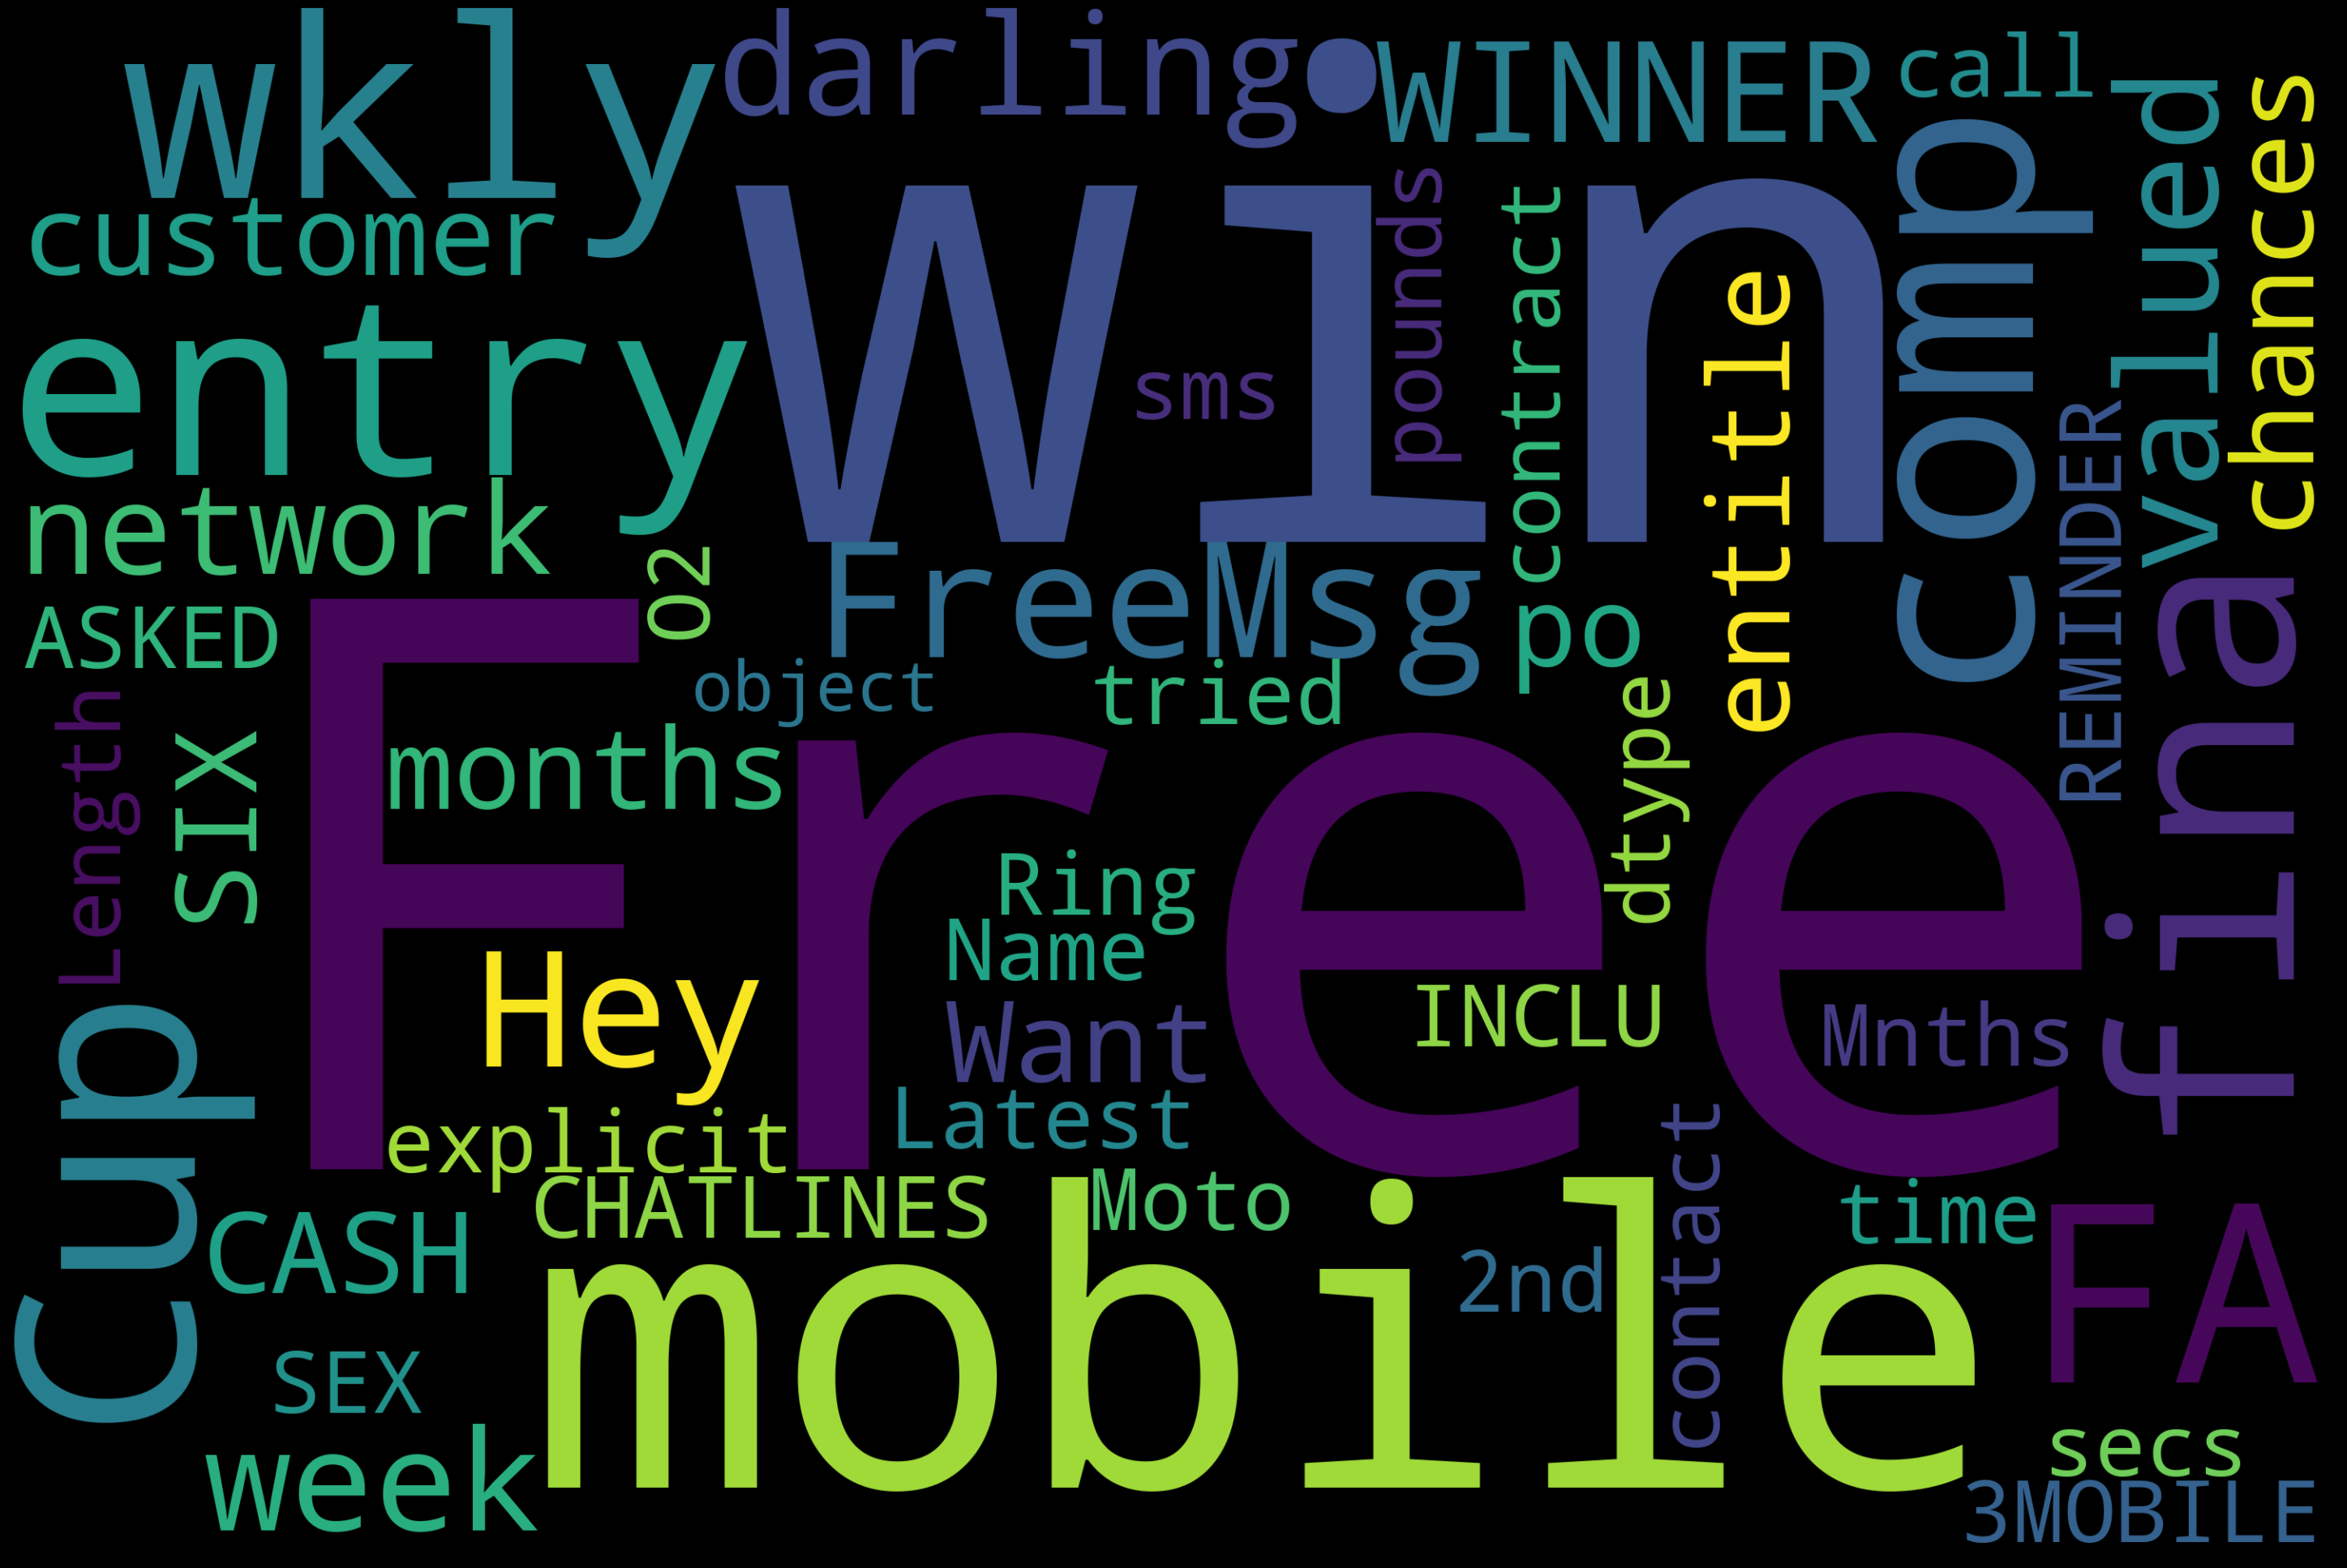

In [58]:
make_wordcloud(df_spam)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


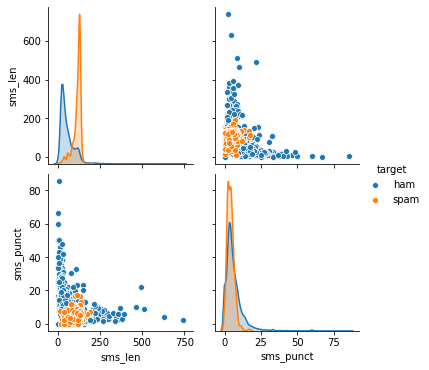

In [10]:
import seaborn as sns
sns.pairplot(df_features,hue='target')

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, t_test = train_test_split(df[['sms','sms_len','sms_punct']],
                                                    df['target'], test_size=0.5)
X_train.head()

,sms,sms_len,sms_punct
2673,"Good afternoon, my boytoy ... How are you feel...",124,6.5
2700,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t...",130,10.1
2307,WIN a year supply of CDs 4 a store of ur choic...,122,4.1
5567,This is the 2nd time we have tried 2 contact u...,132,5.0
1089,Goodmorning today i am late for &lt;DECIMAL&g...,45,9.4


In [12]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)


tfidf_vect_fit = tfidf_vect.fit(X_train['sms'])



tfidf_train = tfidf_vect_fit.transform(X_train['sms'])



tfidf_test= tfidf_vect_fit.transform(X_test['sms'])

X_train_vect = pd.concat([X_train[['sms_len','sms_punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)

X_test_vect = pd.concat([X_test[['sms_len','sms_punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,sms_len,sms_punct,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,5315,5316,5317,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327,5328,5329,5330,5331,5332,5333,5334,5335,5336,5337,5338,5339,5340,5341,5342,5343,5344,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354
0,124,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,130,10.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,122,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,132,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45,9.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
rfc = RandomForestClassifier()
params = {
    'n_estimators': [10, 50, 150],
    'max_depth': [30, 60, 90, None]
}

cv = GridSearchCV(rfc,params,cv=5,n_jobs=-1)
cv_fit = cv.fit(tfidf_train,y_train)
results = pd.DataFrame(cv_fit.cv_results_)

In [17]:
results.sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.733355,0.037645,0.045342,0.000452,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.969534,0.967684,0.980251,0.962298,0.973070,0.970567,0.005963,1
8,3.173939,0.080500,0.051470,0.001806,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.965950,0.965889,0.980251,0.964093,0.973070,0.969851,0.006043,2
10,1.069011,0.029632,0.020844,0.002755,None,50,"{'max_depth': None, 'n_estimators': 50}",0.969534,0.965889,0.980251,0.962298,0.969479,0.969490,0.006008,3
7,1.043838,0.025180,0.018462,0.000233,90,50,"{'max_depth': 90, 'n_estimators': 50}",0.965950,0.964093,0.980251,0.965889,0.969479,0.969133,0.005827,4
3,0.183913,0.003573,0.005539,0.000195,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.964158,0.969479,0.973070,0.960503,0.976661,0.968774,0.005846,5
11,2.969210,0.369056,0.046418,0.005385,None,150,"{'max_depth': None, 'n_estimators': 150}",0.965950,0.964093,0.980251,0.960503,0.973070,0.968773,0.007050,6
4,0.903907,0.016310,0.016934,0.000378,60,50,"{'max_depth': 60, 'n_estimators': 50}",0.965950,0.965889,0.980251,0.962298,0.967684,0.968414,0.006173,7
6,0.214202,0.007474,0.006505,0.000849,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.973118,0.958707,0.978456,0.964093,0.967684,0.968412,0.006876,8
1,0.564852,0.007519,0.017554,0.003576,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.962366,0.960503,0.965889,0.956912,0.964093,0.961952,0.003090,9
0,0.119020,0.003425,0.005396,0.000389,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.960573,0.964093,0.971275,0.949731,0.962298,0.961594,0.006960,10


In [25]:
import joblib
joblib.dump(cv_fit.best_estimator_,'RandomForestClassifier.pkl')

['RandomForestClassifier.pkl']

In [26]:
from sklearn.ensemble import GradientBoostingClassifier


In [27]:
gbc = GradientBoostingClassifier( )
params = {
    'n_estimators': [100,150,300],
    'max_depth': [3,6,12],
    'learning_rate': [0.01,0.1,1]
}

cv_gbc = GridSearchCV(gbc,params,cv=5,n_jobs=-1)
cv_gbc_fit = cv.fit(tfidf_train,y_train)
results = pd.DataFrame(cv_gbc_fit.cv_results_).sort_values('mean_test_score',ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,1.035576,0.021290,0.017654,0.000304,90,50,"{'max_depth': 90, 'n_estimators': 50}",0.967742,0.969479,0.978456,0.964093,0.973070,0.970568,0.004890,1
3,0.188116,0.003554,0.006811,0.002469,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.969534,0.967684,0.976661,0.964093,0.973070,0.970208,0.004337,2
11,2.974085,0.314803,0.047953,0.006422,None,150,"{'max_depth': None, 'n_estimators': 150}",0.969534,0.967684,0.980251,0.964093,0.969479,0.970208,0.005397,2
8,3.090114,0.065965,0.051629,0.003615,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.969534,0.965889,0.978456,0.962298,0.973070,0.969849,0.005608,4
10,1.069667,0.023534,0.018305,0.000509,None,50,"{'max_depth': None, 'n_estimators': 50}",0.967742,0.964093,0.982047,0.960503,0.973070,0.969491,0.007529,5


In [36]:
joblib.dump(cv_gbc_fit.best_estimator_,'GradientBoostingClassifier.pkl')

['GradientBoostingClassifier.pkl']

In [35]:
print(f'Gradient Boosting Best Estimator:\n {cv_gbc_fit.best_estimator_}\n\n Best Score: {round(cv_gbc_fit.best_score_,3)}')
print(f'\n\nRandom Forest Best Estimator:\n {cv_fit.best_estimator_}\n\n Best Score: {round(cv_fit.best_score_,3)}')

Gradient Boosting Best Estimator:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Best Score: 0.971


Random Forest Best Estimator:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                  